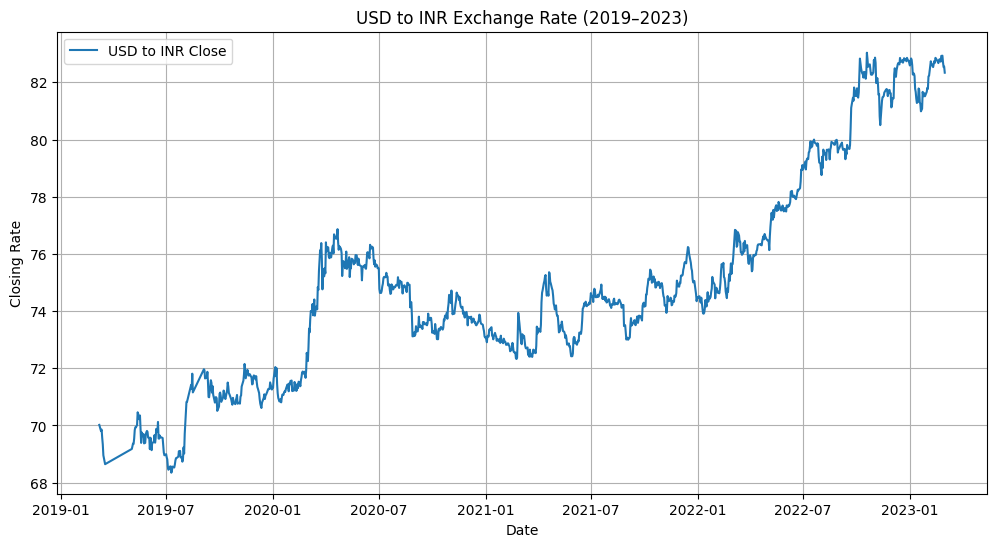

Starting hyperparameter tuning...
Best parameters found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
MAE: 3.2733
RMSE: 13.2813


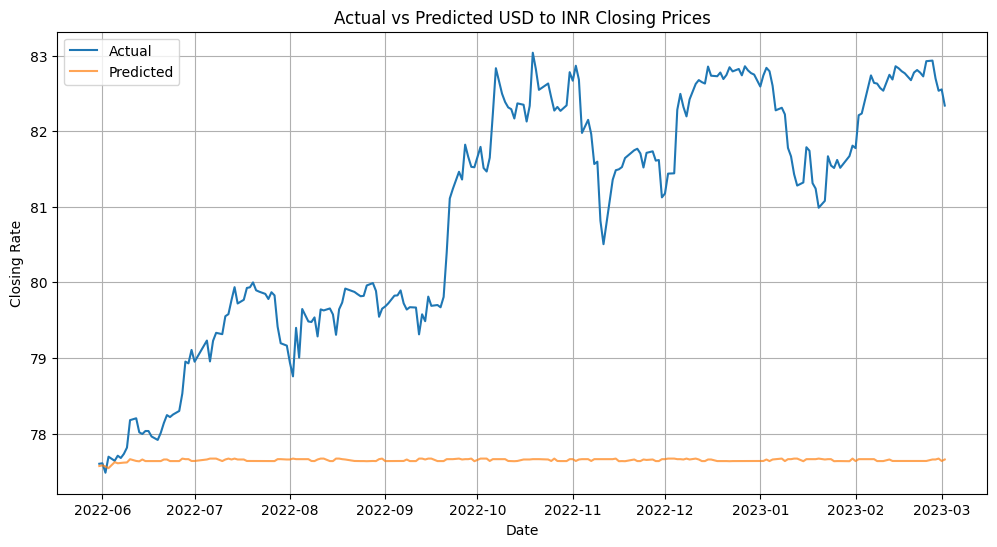

Tuned model saved as inr_model.pkl


In [9]:
# -*- coding: utf-8 -*-
"""INR_Forecasting.ipynb
Automatically generated by Colab.
Revised for hyperparameter tuning using GridSearchCV and TimeSeriesSplit.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pickle

# Load & preprocess data
data = pd.read_csv('HistoricalData.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.sort_values('Date')
data = data[['Date', 'Close/Last']]
data = data.dropna()
data.set_index('Date', inplace=True)

# Visualization of historical close rates
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close/Last'], label='USD to INR Close')
plt.title('USD to INR Exchange Rate (2019–2023)')
plt.xlabel('Date')
plt.ylabel('Closing Rate')
plt.legend()
plt.grid(True)
plt.show()

# Feature engineering: creating lag features and rolling statistics
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['Close/Last'].shift(lag)
data['rolling_mean_3'] = data['Close/Last'].rolling(window=3).mean()
data['rolling_std_3'] = data['Close/Last'].rolling(window=3).std()
data.dropna(inplace=True)

# Prepare training and testing data
X = data.drop('Close/Last', axis=1)
y = data['Close/Last']
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Hyperparameter tuning using GridSearchCV and TimeSeriesSplit
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Use time series cross-validation to respect temporal order
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)

print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

# Use the best estimator from grid search
model = grid_search.best_estimator_

# Prediction and evaluation on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Visualization: Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted USD to INR Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Rate')
plt.grid(True)
plt.show()

# Save the tuned model to a pickle file for later use
with open('inr_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Tuned model saved as inr_model.pkl")
